In [99]:
import xarray as xr
import numpy as np
import paths
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [100]:
#Obs
#Coarse files
# Bicubic files 
#Unet files
#LDM files

In [101]:
obs_temp=xr.open_dataset(paths.DATASETS_TRAINING_DIR + '/TabsD_step1_latlon.nc')["TabsD"].sel(time=slice("2011-01-01","2023-12-31"))

In [102]:
coarse_temp= xr.open_dataset(paths.DATASETS_TRAINING_DIR + '/TabsD_step2_coarse.nc')["TabsD"].sel(time=slice("2011-01-01","2023-12-31"))

In [103]:
bicubic_temp= xr.open_dataset(paths.DATASETS_TRAINING_DIR + '/TabsD_step3_interp.nc')["TabsD"].sel(time=slice("2011-01-01","2023-12-31"))

In [104]:
unet_temp=xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline.nc")["temp"].sel(time=slice("2011-01-01","2023-12-31"))

In [105]:
ldm_temp=xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/single_run_test_LDM_samples.nc")["temp"].sel(time=slice("2011-01-01","2023-12-31"))

In [106]:
def spatial_mean(da):
    return da.mean(dim=['N', 'E'])

In [107]:
obs_mean = spatial_mean(obs_temp)
coarse_mean = spatial_mean(coarse_temp)
bicubic_mean = spatial_mean(bicubic_temp)
unet_mean = spatial_mean(unet_temp)
ldm_mean = spatial_mean(ldm_temp)

In [108]:
print("obs_mean dims:", obs_mean.dims)
print("obs_cycle dims:", obs_cycle.dims)
print("obs_cycle values:", obs_cycle.values)

obs_mean dims: ('time',)
obs_cycle dims: ('month',)
obs_cycle values: [2.244352  1.653478  1.6510929 2.1253662 2.9487731 3.0426052 2.953772
 3.017369  2.2558787 2.6013954 2.5905108 2.600755 ]


In [109]:
print("coarse_flat:", coarse_flat)
print("Any NaN:", np.any(np.isnan(coarse_flat)))
print("Unique values:", np.unique(coarse_flat))
print("Length coarse_flat:", len(coarse_flat))
print("coarse_q:", coarse_q)

coarse_flat: [-3.01532395 -5.08397584 -7.87122477 ...  3.27245698  1.682323
  0.50113265]
Any NaN: False
Unique values: [-16.64594896 -15.49041444 -15.13305092 ...  22.51307692  22.83722638
  23.08958849]
Length coarse_flat: 4748
coarse_q: [-16.64594896 -15.46064773 -15.10567005 ...  22.49643826  22.81022626
  23.08958849]


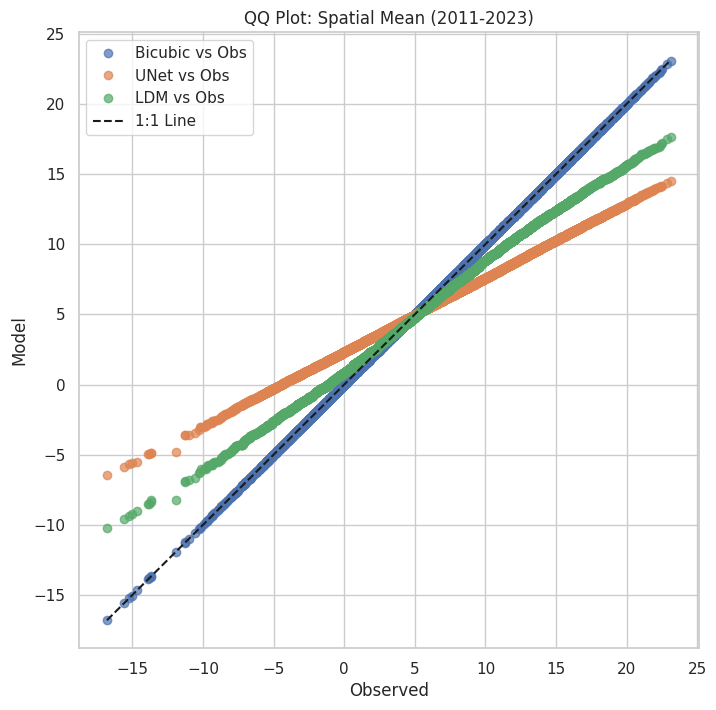

In [110]:
plt.figure(figsize=(8, 8))

# Flatten to 1D arrays (drop NaNs if any)
obs_flat = obs_mean.values.flatten()
coarse_flat = coarse_mean.values.flatten()
bicubic_flat = bicubic_mean.values.flatten()
unet_flat = unet_mean.values.flatten()
ldm_flat = ldm_mean.values.flatten()

# Remove NaNs
obs_flat = obs_flat[~np.isnan(obs_flat)]
coarse_flat = coarse_flat[~np.isnan(coarse_flat)]
bicubic_flat = bicubic_flat[~np.isnan(bicubic_flat)]
unet_flat = unet_flat[~np.isnan(unet_flat)]
ldm_flat = ldm_flat[~np.isnan(ldm_flat)]

# Get common quantiles
quantiles = np.linspace(0, 1, min(len(obs_flat), len(coarse_flat), len(bicubic_flat), len(unet_flat), len(ldm_flat)))

obs_q = np.quantile(obs_flat, quantiles)
coarse_q = np.quantile(coarse_flat, quantiles)
bicubic_q = np.quantile(bicubic_flat, quantiles)
unet_q = np.quantile(unet_flat, quantiles)
ldm_q = np.quantile(ldm_flat, quantiles)

plt.plot(obs_q, bicubic_q, 'o', label='Bicubic vs Obs', alpha=0.7)
plt.plot(obs_q, unet_q, 'o', label='UNet vs Obs', alpha=0.7)
plt.plot(obs_q, ldm_q, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q.min(), obs_q.max()], [obs_q.min(), obs_q.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed')
plt.ylabel('Model')
plt.title('QQ Plot: Spatial Mean (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

In [112]:
from closest_grid_cell import select_nearest_grid_cell

# Define city coordinates
locarno_lat, locarno_lon = 46.1709, 8.7995
bern_lat, bern_lon = 46.9480, 7.4474

# Extract time series for Locarno
obs_locarno = select_nearest_grid_cell(obs_temp, locarno_lat, locarno_lon, var_name="TabsD")['data'].values
coarse_locarno = select_nearest_grid_cell(coarse_temp, locarno_lat, locarno_lon, var_name="TabsD")['data'].values
bicubic_locarno = select_nearest_grid_cell(bicubic_temp, locarno_lat, locarno_lon, var_name="TabsD")['data'].values
unet_locarno = select_nearest_grid_cell(unet_temp, locarno_lat, locarno_lon, var_name="temp")['data'].values
ldm_locarno = select_nearest_grid_cell(ldm_temp, locarno_lat, locarno_lon, var_name="temp")['data'].values

# Extract time series for Bern
obs_bern = select_nearest_grid_cell(obs_temp, bern_lat, bern_lon, var_name="TabsD")['data'].values
coarse_bern = select_nearest_grid_cell(coarse_temp, bern_lat, bern_lon, var_name="TabsD")['data'].values
bicubic_bern = select_nearest_grid_cell(bicubic_temp, bern_lat, bern_lon, var_name="TabsD")['data'].values
unet_bern = select_nearest_grid_cell(unet_temp, bern_lat, bern_lon, var_name="temp")['data'].values
ldm_bern = select_nearest_grid_cell(ldm_temp, bern_lat, bern_lon, var_name="temp")['data'].values

# Remove NaNs
def clean(arr):
    return arr[~np.isnan(arr)]

obs_locarno = clean(obs_locarno)
coarse_locarno = clean(coarse_locarno)
bicubic_locarno = clean(bicubic_locarno)
unet_locarno = clean(unet_locarno)
ldm_locarno = clean(ldm_locarno)

obs_bern = clean(obs_bern)
coarse_bern = clean(coarse_bern)
bicubic_bern = clean(bicubic_bern)
unet_bern = clean(unet_bern)
ldm_bern = clean(ldm_bern)

# Get common quantiles for Locarno
quantiles_locarno = np.linspace(0, 1, min(len(obs_locarno), len(coarse_locarno), len(bicubic_locarno), len(unet_locarno), len(ldm_locarno)))
obs_q_locarno = np.quantile(obs_locarno, quantiles_locarno)
coarse_q_locarno = np.quantile(coarse_locarno, quantiles_locarno)
bicubic_q_locarno = np.quantile(bicubic_locarno, quantiles_locarno)
unet_q_locarno = np.quantile(unet_locarno, quantiles_locarno)
ldm_q_locarno = np.quantile(ldm_locarno, quantiles_locarno)

# Get common quantiles for Bern
quantiles_bern = np.linspace(0, 1, min(len(obs_bern), len(coarse_bern), len(bicubic_bern), len(unet_bern), len(ldm_bern)))
obs_q_bern = np.quantile(obs_bern, quantiles_bern)
coarse_q_bern = np.quantile(coarse_bern, quantiles_bern)
bicubic_q_bern = np.quantile(bicubic_bern, quantiles_bern)
unet_q_bern = np.quantile(unet_bern, quantiles_bern)
ldm_q_bern = np.quantile(ldm_bern, quantiles_bern)

# Plot QQ for Locarno
plt.figure(figsize=(8, 8))
plt.plot(obs_q_locarno, coarse_q_locarno, 'o', label='Coarse vs Obs', alpha=0.7)
plt.plot(obs_q_locarno, bicubic_q_locarno, 'o', label='Bicubic vs Obs', alpha=0.7)
plt.plot(obs_q_locarno, unet_q_locarno, 'o', label='UNet vs Obs', alpha=0.7)
plt.plot(obs_q_locarno, ldm_q_locarno, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_locarno.min(), obs_q_locarno.max()], [obs_q_locarno.min(), obs_q_locarno.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Locarno)')
plt.ylabel('Model Quantiles (Locarno)')
plt.title('QQ Plot: Locarno (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

# Plot QQ for Bern
plt.figure(figsize=(8, 8))
plt.plot(obs_q_bern, coarse_q_bern, 'o', label='Coarse vs Obs', alpha=0.7)
plt.plot(obs_q_bern, bicubic_q_bern, 'o', label='Bicubic vs Obs', alpha=0.7)
plt.plot(obs_q_bern, unet_q_bern, 'o', label='UNet vs Obs', alpha=0.7)
plt.plot(obs_q_bern, ldm_q_bern, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_bern.min(), obs_q_bern.max()], [obs_q_bern.min(), obs_q_bern.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Bern)')
plt.ylabel('Model Quantiles (Bern)')
plt.title('QQ Plot: Bern (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

AttributeError: 'DataArray' object has no attribute 'data_vars'